In [1]:
import pandas as pd
import numpy as np

## DATA COLLECTION 
from collections import OrderedDict

## DATA VISUALIZATION LIBRARIES
import matplotlib.pyplot as plt
import seaborn as sns

## 
from statsmodels.stats.outliers_influence import variance_inflation_factor

## DATA TRANSFORMATION LIBRARIES
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## WARNING LIBRARIES

import warnings 
warnings.filterwarnings('ignore')


## 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRFRegressor

## clustereing libs
from sklearn.cluster import KMeans

In [2]:
df = pd.read_excel("Capstone Project.xlsx")
df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29


In [3]:
## making a copy of the data
df_copy = df

In [4]:
# finding descriptive statistics

In [5]:
def custom_summary(my_df):
    result = []
    for col in my_df.columns:
        if my_df[col].dtype != object:
            stats = OrderedDict({
                "Feature Name" : col,
                "Count" : my_df[col].count(),
                "Minimum" : my_df[col].min(),
                "Quartile1" : my_df[col].quantile(0.25),
                "Mean" : my_df[col].mean(),
                "Median" : my_df[col].median(),
                "Quartile3" : my_df[col].quantile(0.75),
                "Maximum" : my_df[col].max(),
                "Variance" : my_df[col].var(),
                "Standard Deviation" : my_df[col].std(),
                "Skewness" : my_df[col].skew(),
                "Kurtosis" : my_df[col].kurt(),
                "IQR" : my_df[col].quantile(0.75) - my_df[col].quantile(0.25)
            })
            result.append(stats) 
    result_df = pd.DataFrame(result)
    
    ## Skewness type
    skew_type = []
    for i in result_df["Skewness"]:
        if i < -1:
            skew_type.append("Highly Negatively Skewed")
        elif -1 < i < -0.5:
            skew_type.append("Moderately Negatively Skewed")
        elif -0.5 < i < 0:
            skew_type.append("Fairly Negatively Skewed")
        elif 0 < i < 0.5:
            skew_type.append("Fairly Positively Skewed")
        elif 0.5 < i < 1:
            skew_type.append("Moderately positively Skewed")
        elif i > 1:
            skew_type.append("Highly Positively Skewed")
    result_df["Skewness Type"] = skew_type
    
    ## Kurtosis Type
    kurt_type = []
    for j in result_df["Kurtosis"]:
        if j >= 1:
            kurt_type.append("Leptokurtic")
        elif j <= -1:
            kurt_type.append("Platykurtic")
        else:
            kurt_type.append("Mesokurtic")
    result_df["Kurtosis Type"] = kurt_type
    
    # Outliers
    upperlim = stats["Quartile3"] + 1.5 * stats["IQR"]
    lowerlim = stats["Quartile1"] - 1.5 * stats["IQR"]
    
    if len([x for x in my_df[col] if x < lowerlim or x > upperlim]) > 0:
        outlier_comment = "Has outliers"
    else :
        outlier_comment = "No outliers"
        
    result_df["outlier_comment"] = outlier_comment
    
    return result_df

In [6]:
custom_summary(df)

,Feature Name,Count,Minimum,Quartile1,Mean,Median,Quartile3,Maximum,Variance,Standard Deviation,Skewness,Kurtosis,IQR,Skewness Type,Kurtosis Type,outlier_comment
0,cement,1030,102.00,192.375,281.167864,272.900,350.000,540.0,10921.580220,104.506364,0.509481,-0.520652,157.625,Moderately positively Skewed,Mesokurtic,Has outliers
1,slag,1030,0.00,0.000,73.895825,22.000,142.950,359.4,7444.124812,86.279342,0.800717,-0.508175,142.950,Moderately positively Skewed,Mesokurtic,Has outliers
2,ash,1030,0.00,0.000,54.188350,0.000,118.300,200.1,4095.616541,63.997004,0.537354,-1.328746,118.300,Moderately positively Skewed,Platykurtic,Has outliers
3,water,1030,121.80,164.900,181.567282,185.000,192.000,247.0,456.002651,21.354219,0.074628,0.122082,27.100,Fairly Positively Skewed,Mesokurtic,Has outliers
4,superplastic,1030,0.00,0.000,6.204660,6.400,10.200,32.2,35.686781,5.973841,0.907203,1.411269,10.200,Moderately positively Skewed,Leptokurtic,Has outliers
5,coarseagg,1030,801.00,932.000,972.918932,968.000,1029.400,1145.0,6045.677357,77.753954,-0.040220,-0.599016,97.400,Fairly Negatively Skewed,Mesokurtic,Has outliers
6,fineagg,1030,594.00,730.950,773.580485,779.500,824.000,992.6,6428.187792,80.175980,-0.253010,-0.102177,93.050,Fairly Negatively Skewed,Mesokurtic,Has outliers
7,age,1030,1.00,7.000,45.662136,28.000,56.000,365.0,3990.437729,63.169912,3.269177,12.168989,49.000,Highly Positively Skewed,Leptokurtic,Has outliers
8,strength,1030,2.33,23.710,35.817961,34.445,46.135,82.6,279.081814,16.705742,0.416977,-0.313725,22.425,Fairly Positively Skewed,Mesokurtic,Has outliers


## Analysis of custom summary
* From the above analysis all the columns have outliers
 for all the columns count is same, so there are no null values
* There are no categorical data
* For ash, slag and superplstic quartile1 is zero 
* For ash , median is zero
* As max age is 365, its yearly data
* Age is hightly positively skewed

# Treating outliers
* Quartile (STANDARD BOX PLOT)
* Standard Deviation

In [7]:
def replace_outliers(df, col, method = "Quartile", strategy = "Median"):
    col_data = df[col]
    
    if method == "Quartile":
        q2 = df[col].median()
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lowerlim = q1 - 1.5 * iqr
        upperlim = q3 + 1.5 * iqr
        
        
    elif method == "Standard Deviation":
        col_mean = df[col].mean()
        col_std = df[col].std()
        lowerlim = col_mean - 2 * col_std
        upperlim = col_mean + 2 * col_std
        
    outlier = df.loc[(col_data < lowerlim) | (col_data > upperlim), col]
    outlier_density = len(outlier) / len(df)
    
    if len(outlier) == 0:
        print(f"The {col} has no outliers")
    else:
        print(f"The {col} has outliers")
        print(f"Outlier density is", outlier_density)
        
        
        
    if strategy == 'Median':
        df.loc[(col_data < lowerlim) | (col_data > upperlim), col] = df[col].median()
       
    elif strategy == 'Mean':
            df.loc[(col_data < lowerlim) | (col_data > upperlim), col] = df[col].mean()

### ODT PLOTS

IN ODT, WE HAVE THREE PLOTS TO SHOW IT TO CLIENTS:
1. BOX PLOT
2. HISTOGRAM WITH OUTLIERS 
3. HISTOGRAM WITHOUT OUTLIERS

In [8]:
def odt_plots(df, col):
    f,(ax1, ax2, ax3) = plt.subplots(1,3, figsize = (20,20))
    
    
    ## DESCRIPTIVE STATS USING BOX PLOT
    sns.boxplot(df[col], ax = ax1)
    ax1.set_title(col + 'BOX PLOT')
    ax1.set_xlabel('BOX PLOT')
    ax1.set_ylabel('VALUES')
    
    
    ## HISTOGRAM WITH OUTLIERS
    sns.distplot(df[col], ax = ax2)
    ax2.set_title(col + 'HISTOGRAM WITH OUTLIERS')
    ax2.set_xlabel('DENSITY')
    ax2.set_ylabel('VALUES')
    
    ## HISTOGRAM WITHOUT OUTLIERS
    y = replace_outliers(df, col)
    sns.distplot(df[col], ax = ax3)
    ax3.set_title(col + 'HISTOGRAM WITHOUT OUTLIERS')
    ax3.set_xlabel('DENSITY')
    ax3.set_ylabel('VALUES')

The cement has no outliers
The slag has outliers
Outlier density is 0.001941747572815534
The ash has no outliers
The water has outliers
Outlier density is 0.008737864077669903
The superplastic has outliers
Outlier density is 0.009708737864077669
The coarseagg has no outliers
The fineagg has outliers
Outlier density is 0.0048543689320388345
The age has outliers
Outlier density is 0.05728155339805825
The strength has outliers
Outlier density is 0.003883495145631068


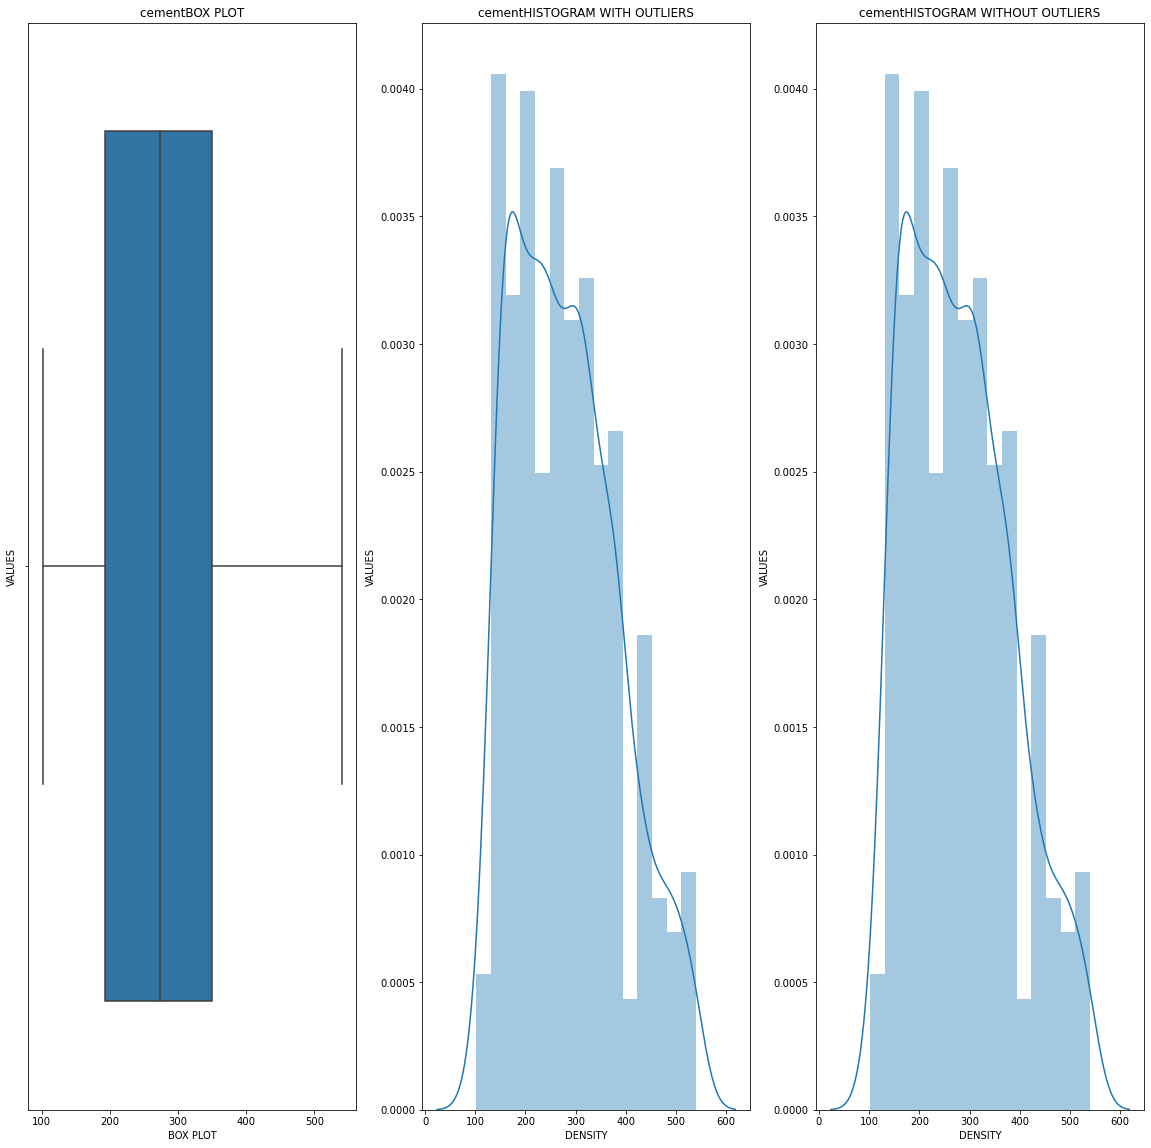

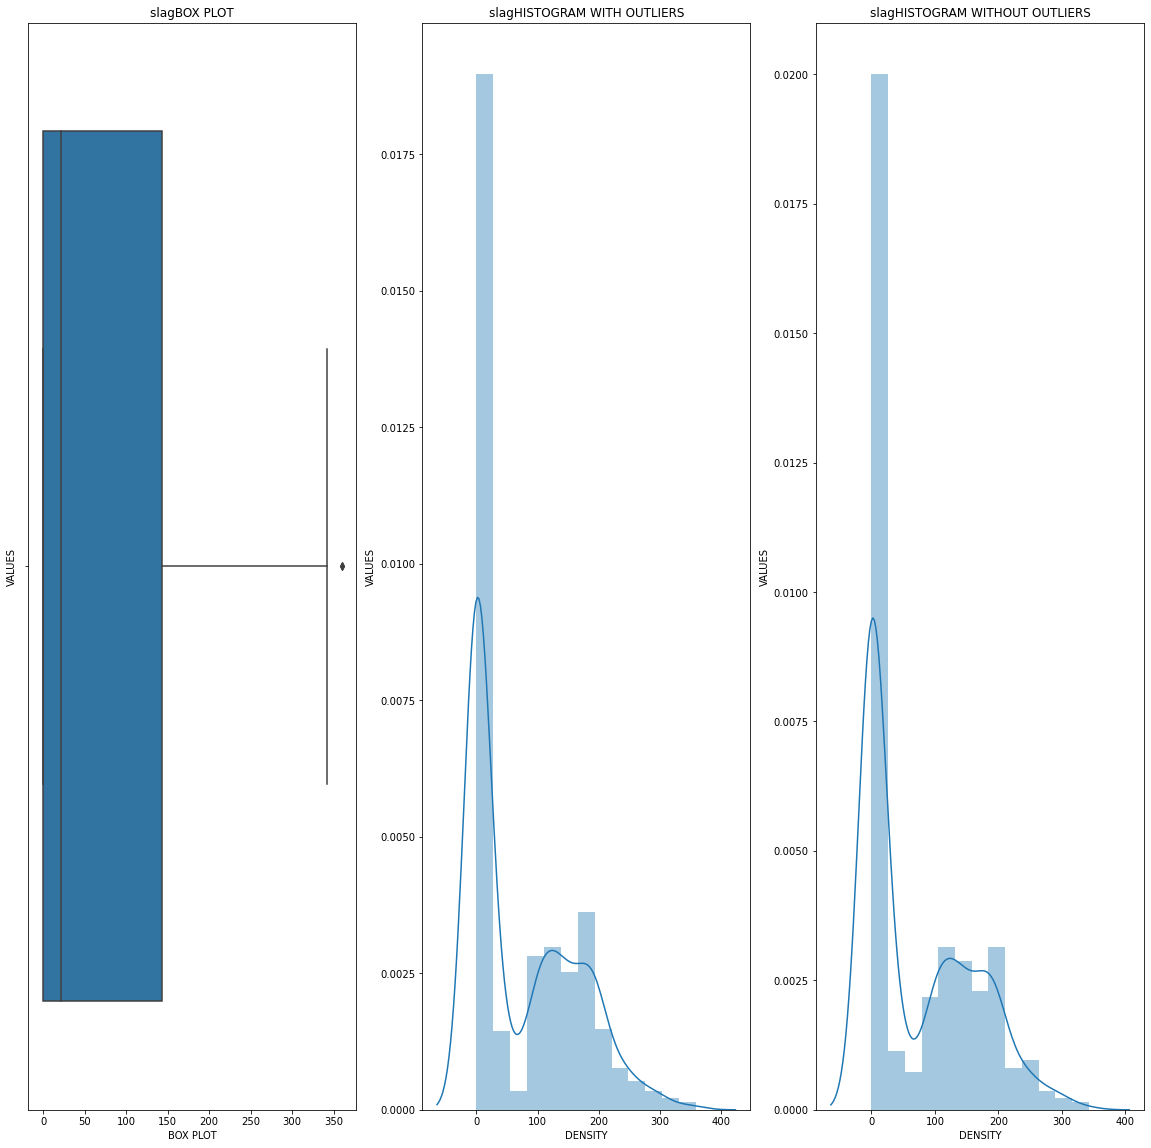

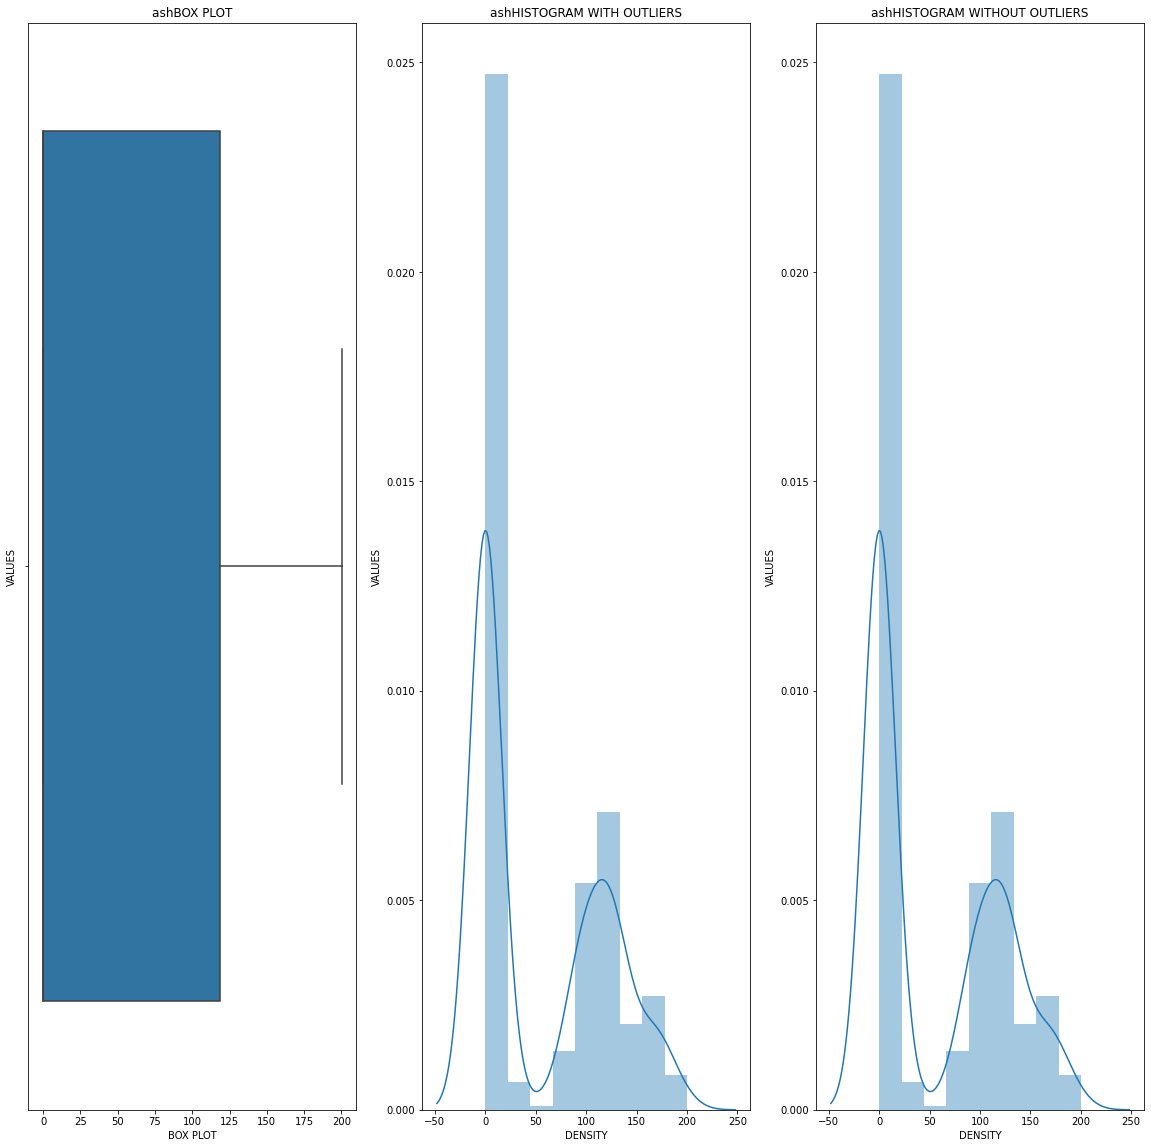

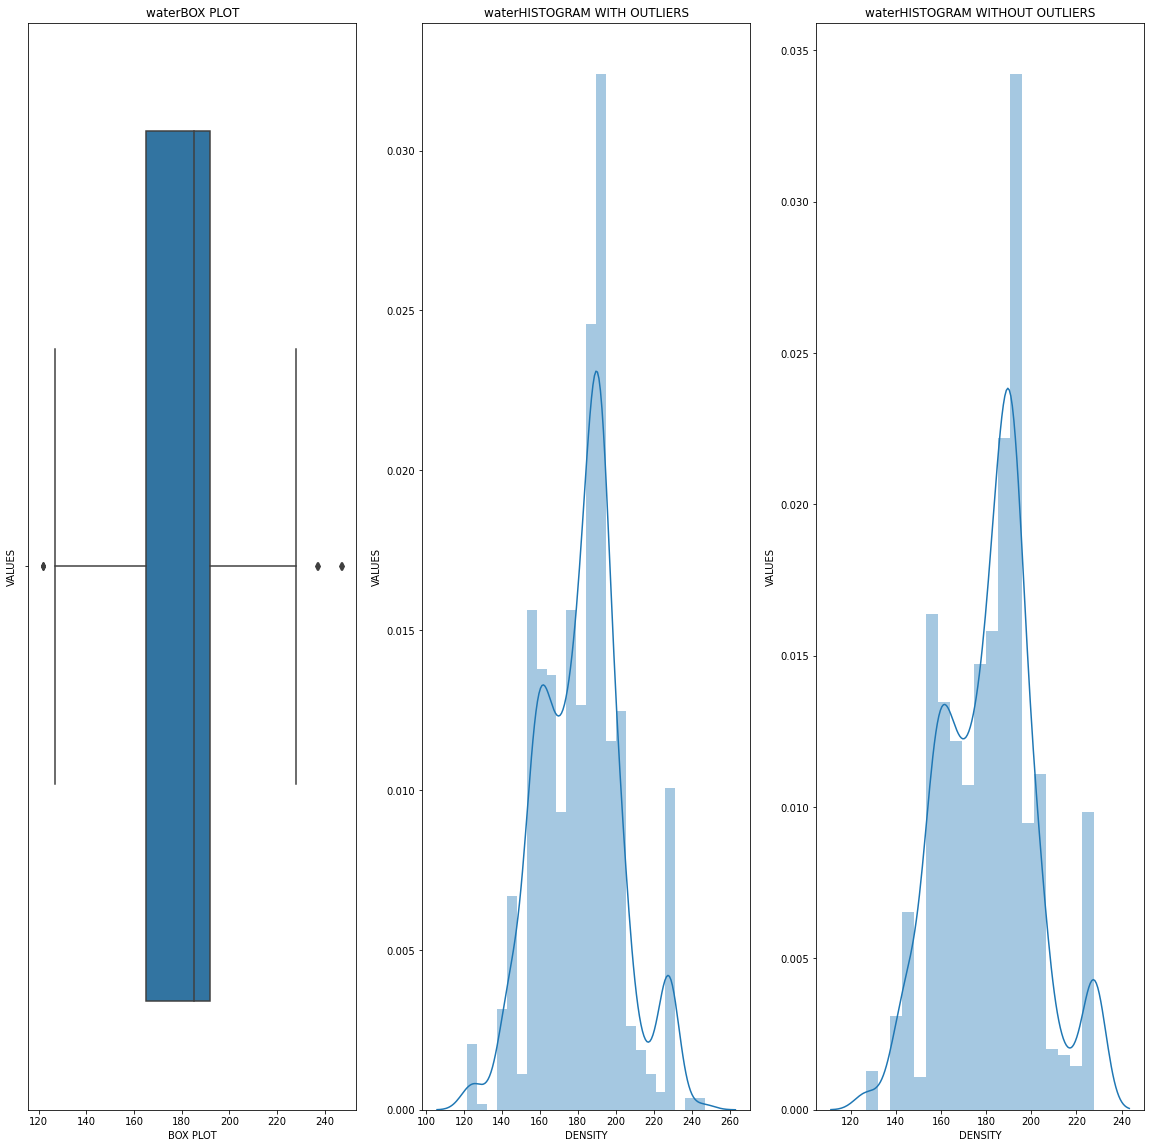

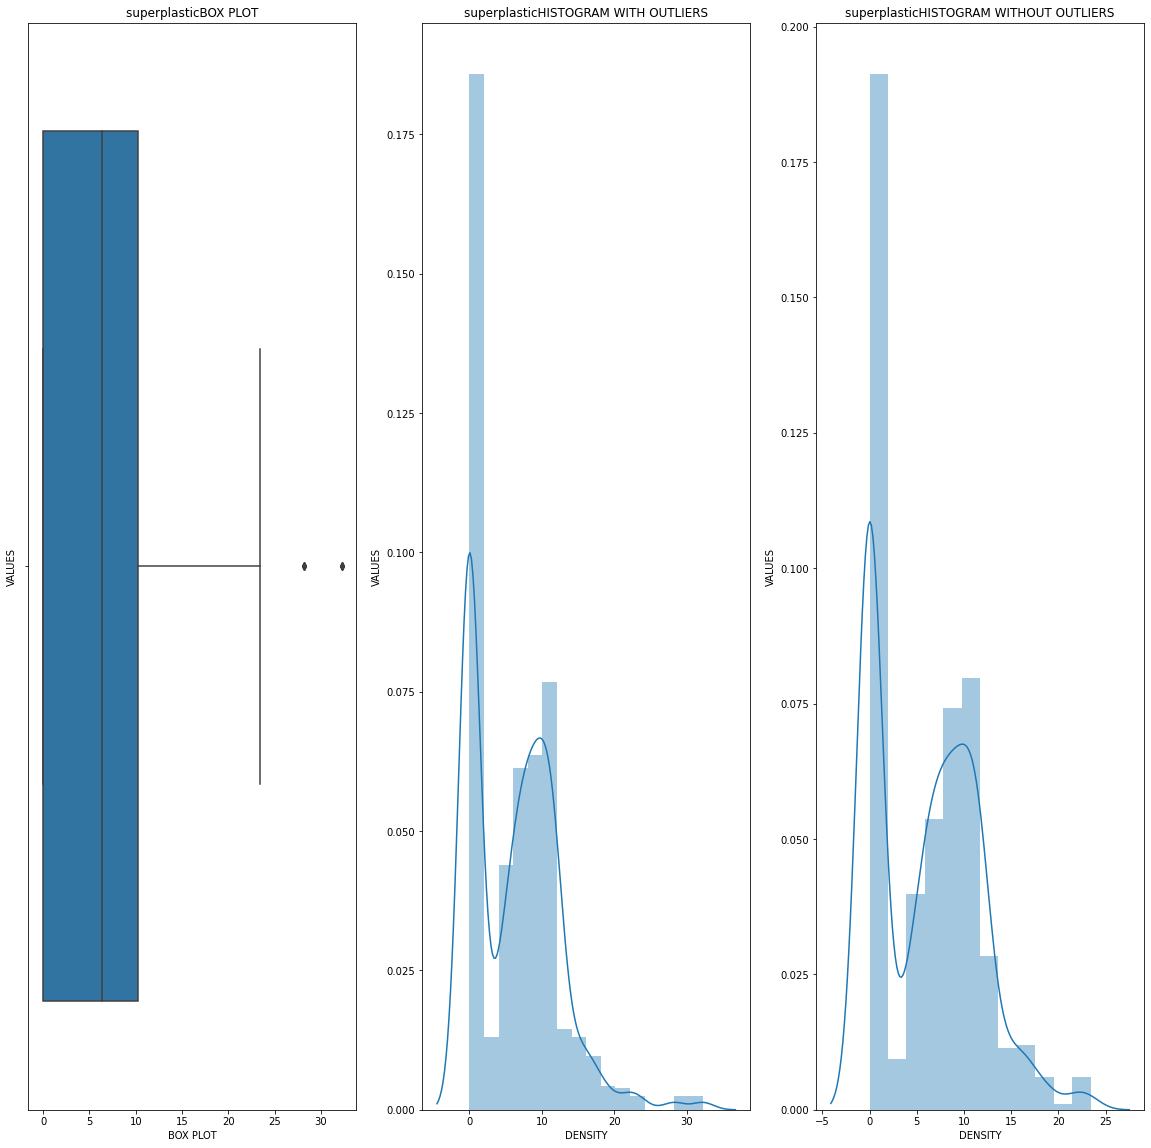

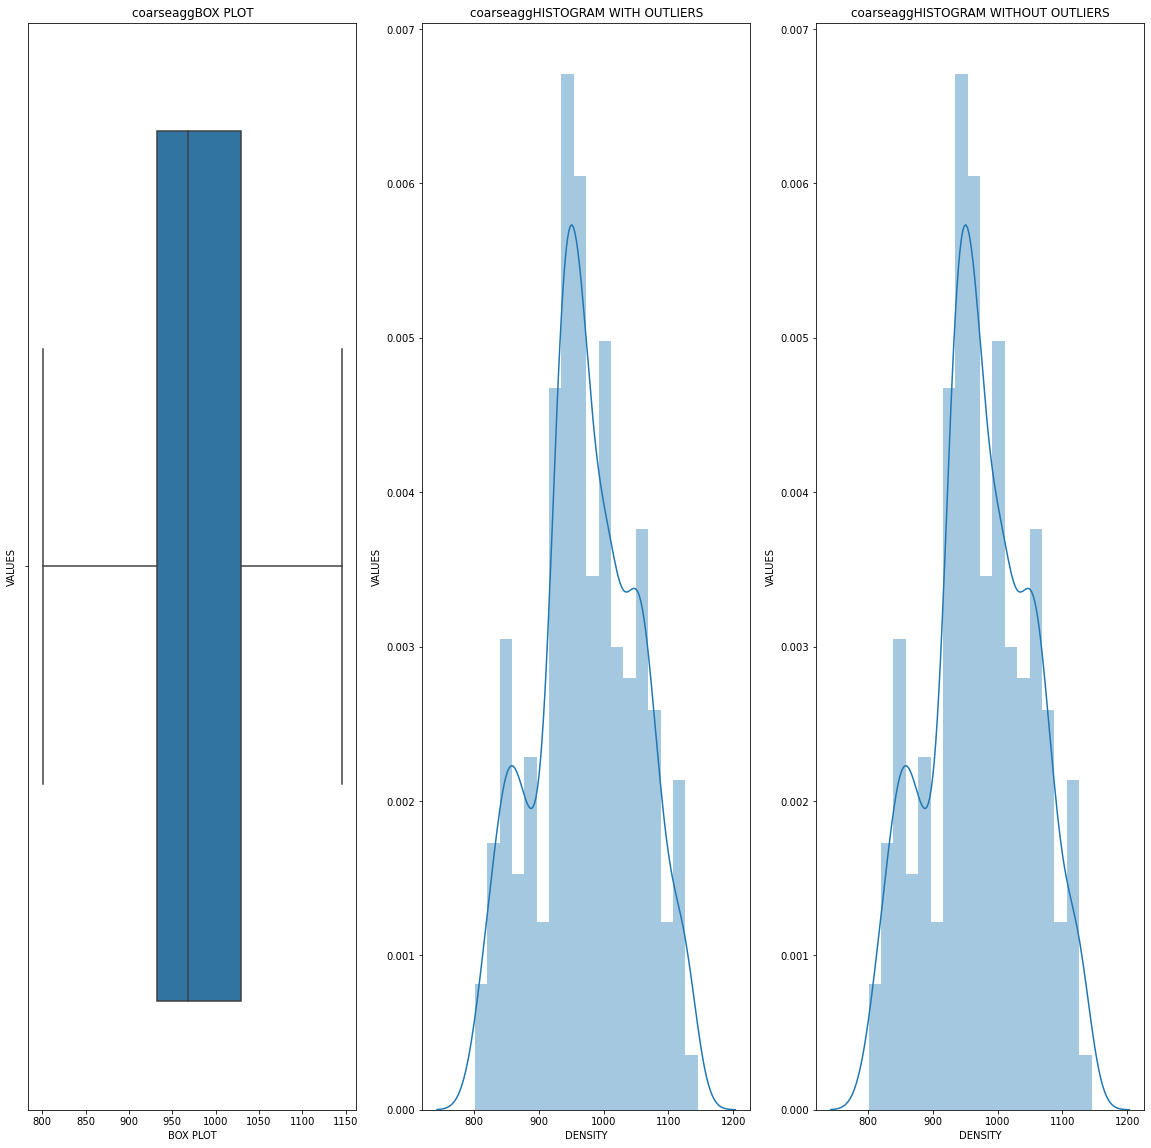

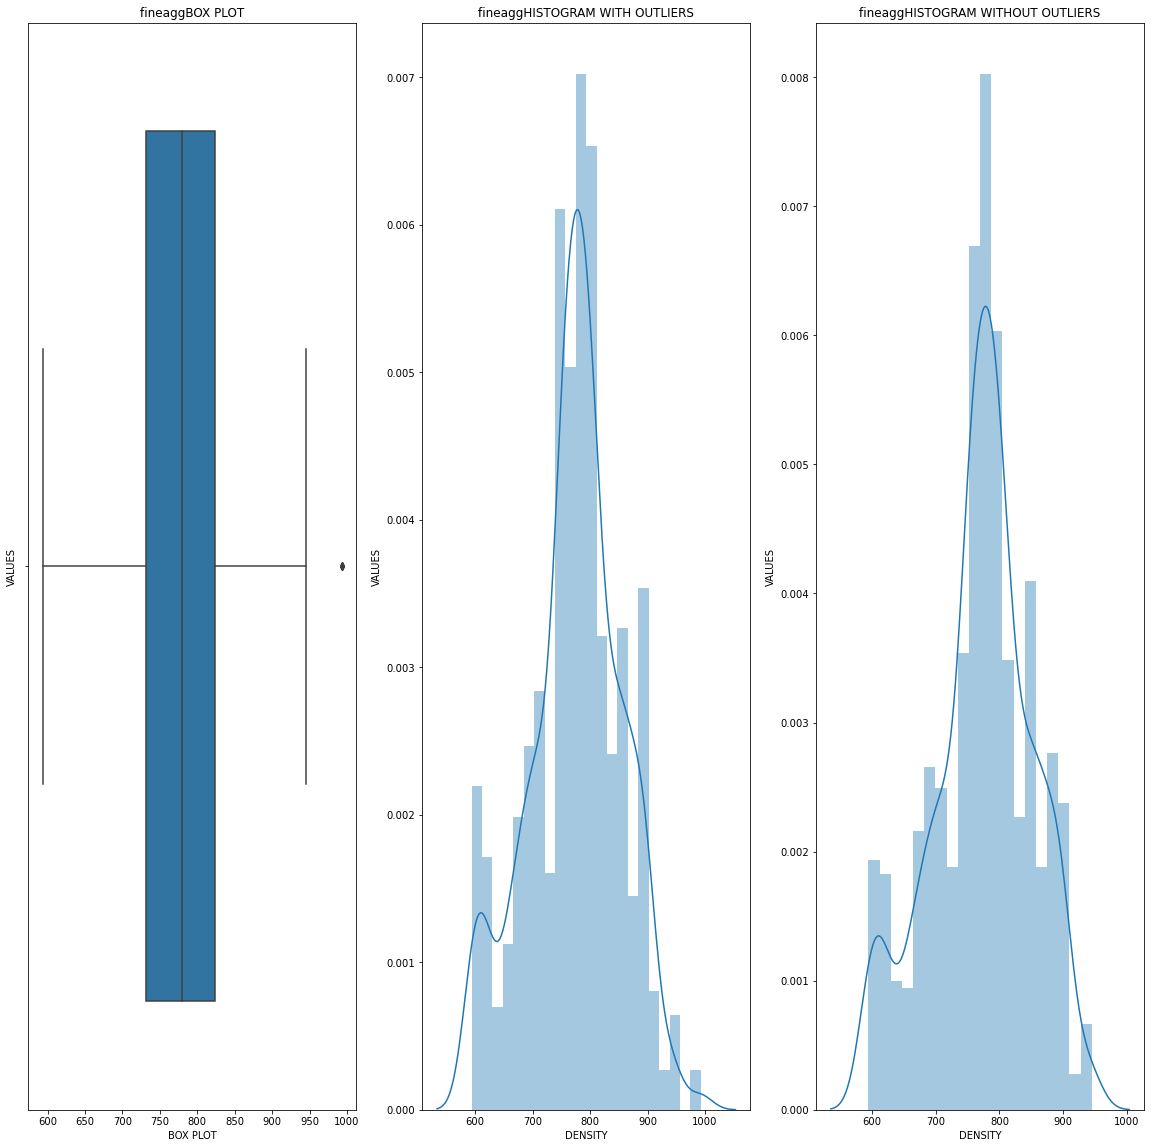

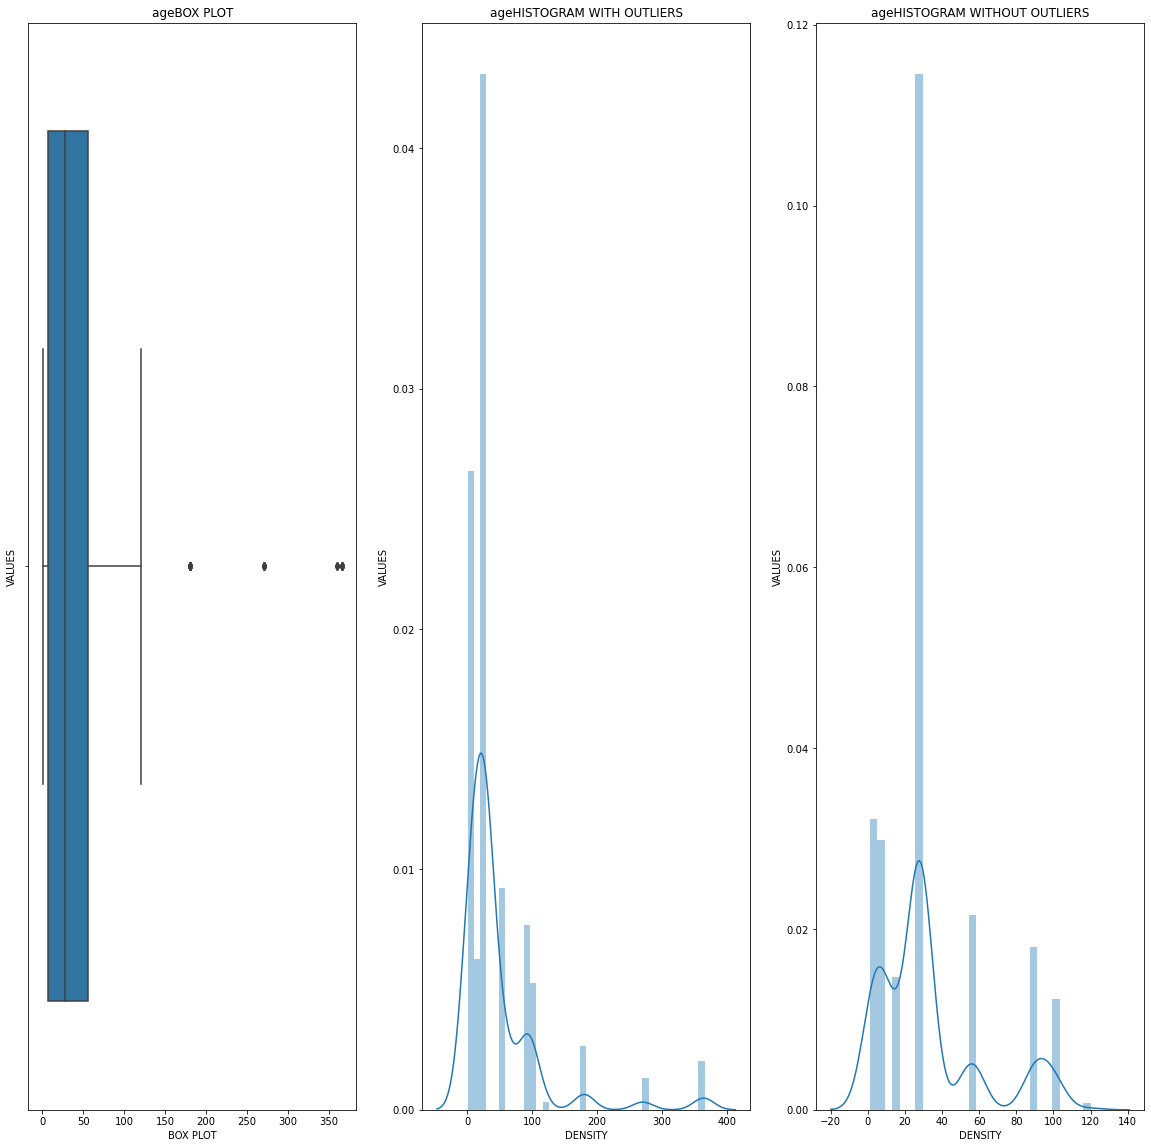

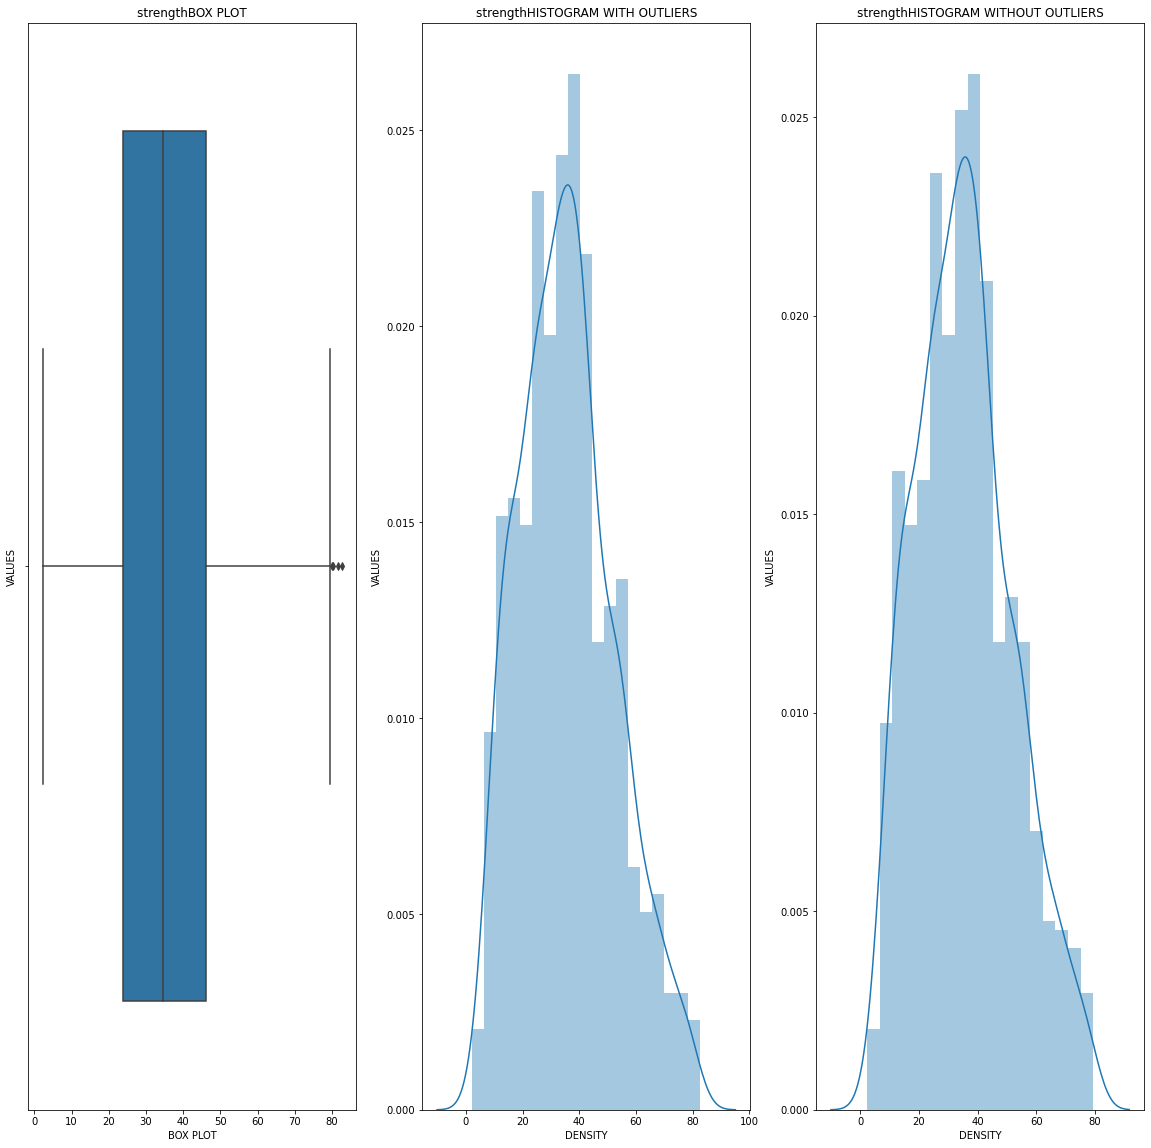

In [9]:
for col in df.columns:
    odt_plots(df,col)

### MULTI-VARIATE ANALYSIS 

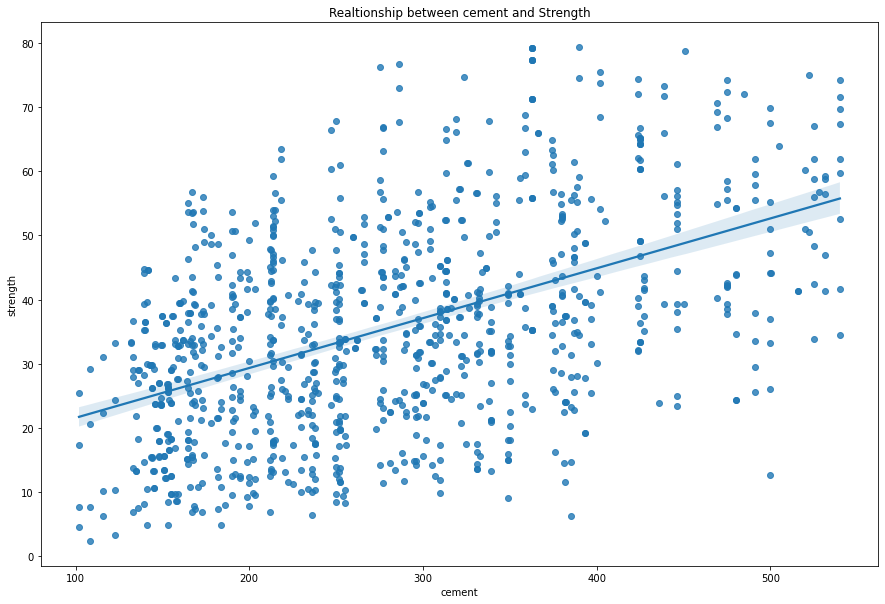

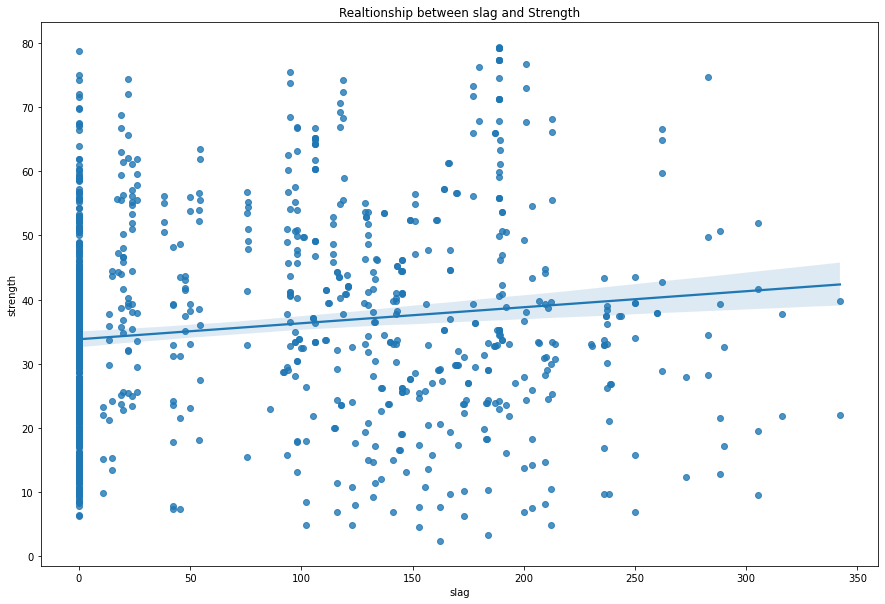

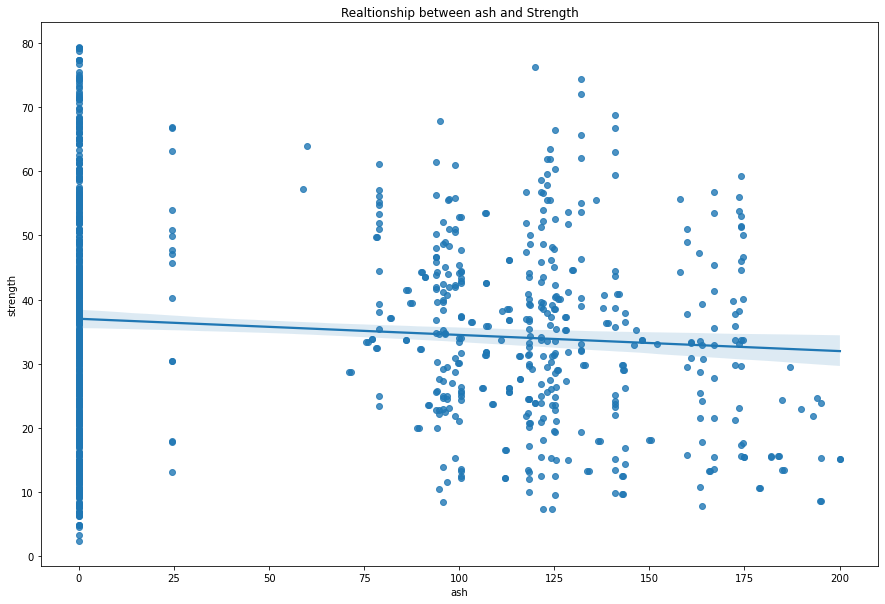

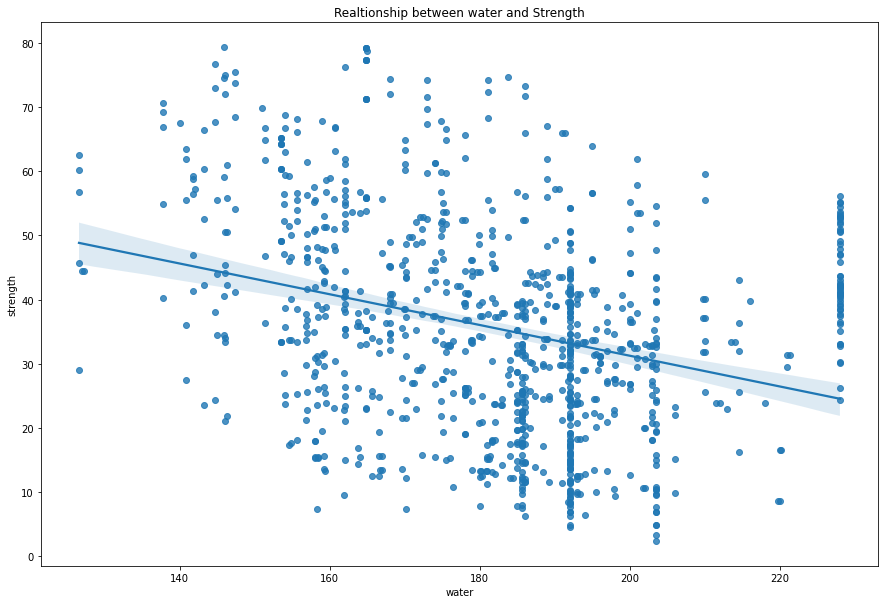

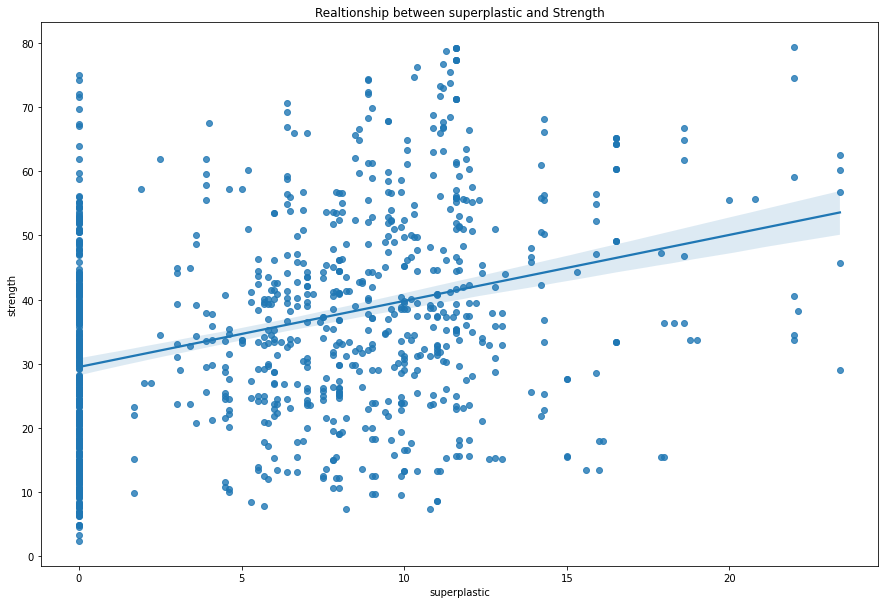

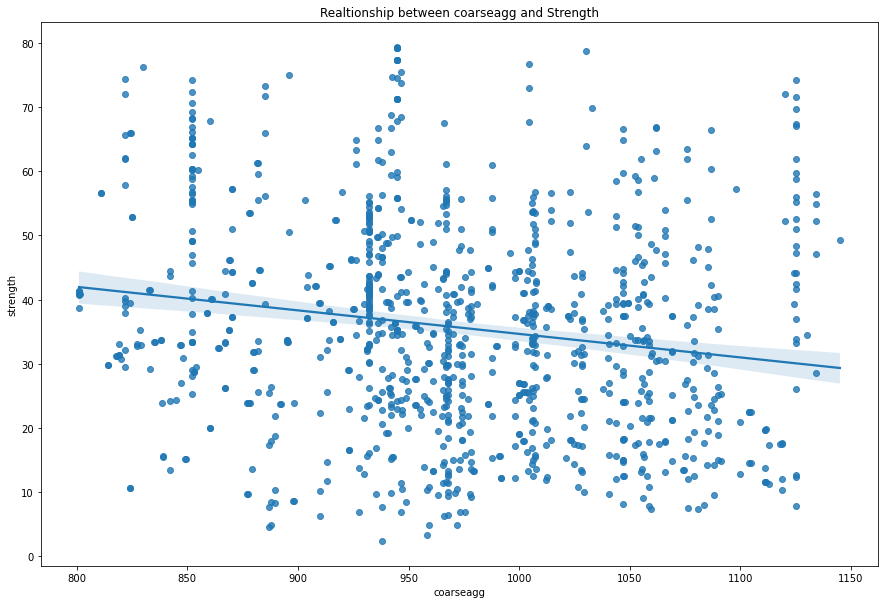

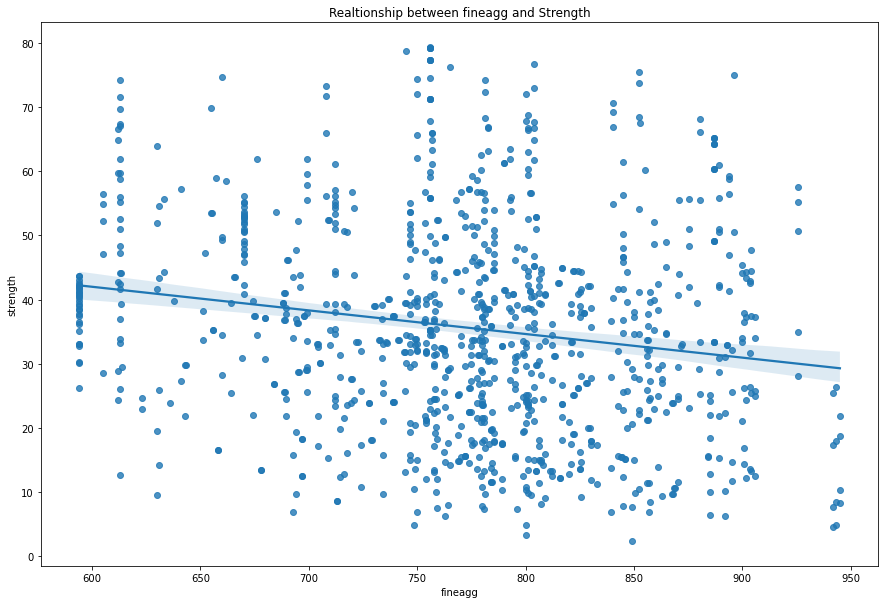

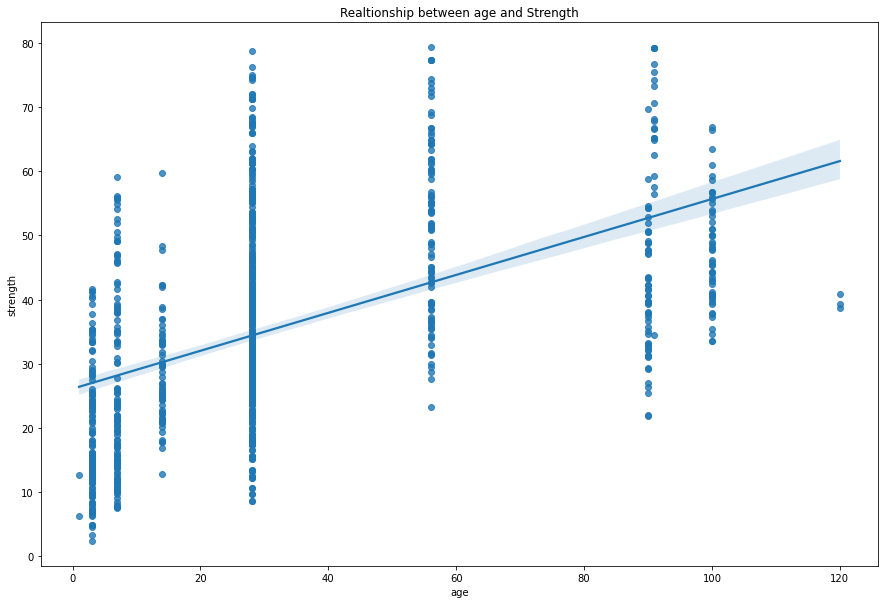

In [10]:
for col in df.columns:
    if col != 'strength':
        f, ax1 = plt.subplots(figsize = (15, 10))
        sns.regplot(x = df[col], y= df['strength'], ax = ax1)
        ax1.set_title(f'Realtionship between {col} and Strength')

### ANALYSIS:
1. CEMENT AND STRENTH HAS A VERY HIGH CO-RELATION
2. SLAG AND STRENGTH ARE HAVING +VE CO-RELATION 
3. ASH AND STRENGTH ARE HAVING +VE CO-RELATION
4. WATER AND STRENGTH HAVING VERY HIGH +VE CO-RELATION 
5. SUPERPLASTIC AND STRENGTH ARE HAVING VERY HIGH +VE CO-RELATION
6. COARSEAGG AND STRENGTH ARE HAVING +VE CO-RELATION
7. FINEAGG AND STRENGTH ARE HAVING +VE CO-RELATION
8. AGE AND STRENGTH ARE HAVING +VE CO-RELATION

In [11]:
def corr_target(df, target):
    ind_var = df.drop(target, axis = 1).columns
    corr_result = []
    for col in ind_var:
        corr_result.append(df[target].corr(df[col]))
    result_df = pd.DataFrame([ind_var, corr_result], index = ['Variable', 'Co-Realtion']).T ## T is for transpose
    
    
    return result_df.sort_values('Co-Realtion', ascending = False)

In [12]:
corr_target(df, 'strength') ## only look atvnmber no negative or positive

,Variable,Co-Realtion
7,age,0.499711
0,cement,0.493518
4,superplastic,0.342633
1,slag,0.129561
2,ash,-0.097973
5,coarseagg,-0.173234
6,fineagg,-0.176113
3,water,-0.300043


### ANALYASIS

1. AGE > CEMENT > SUPERPLASTIC > WATER > COARSEAGG > FINEAGG > SLAG > ASH

# checking multi-colinearity 

<AxesSubplot:>

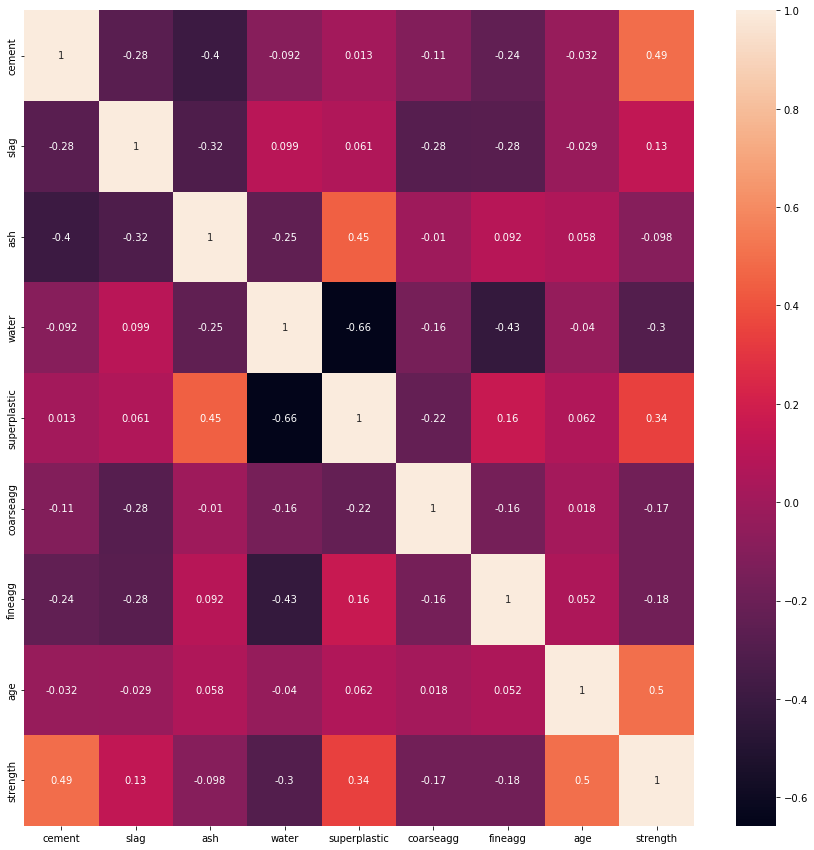

In [13]:
corr = df.corr()
f, ax = plt.subplots(figsize = (15,15))
sns.heatmap(corr, annot= True)

### ANALYSIS
 COREALTION VALUE > 30%
1. CEMENT AND ASH IS 40%
2. CEMENT AND STRENGTH IS 49%

3. SLAG AND ASH IS 32%

4. ASH AND SUPERPLASTIC IS 45%

5. STRENGTH AND SUPERPLASTIC IS 33%

6. AGE AND STRENGTH IS 54%

7. WATER AND SUPERPLASTIC IS 66%

WE SHOULD DO PCA IF HAVING MULTI- COLINEARITY IN THE DATA BUT ORGINALITY OF THE DATA IS LOST.
WE NEED TO PROVE IT TO CLIENT THROUGH TWO TEST THAT WE HAVE MULTI- COLINEARITY. 

#  VARIANCE INFLATION FACTOR (VIF)

* IN VIF, WE REGRESS EACH INDEPENDENT VARIABLE WITH ALL OTHER AND FIND OUT THE R2_SCORE
* THE FORMULA FOR VIF IS: VIF = 1/R2_SCORE
* IF VIF > 5, THEN MULTI- COLINEARITY EXISTS 

In [14]:
def vif_test(ind_var):
    result_df = pd.DataFrame()
    result_df['feature'] = ind_var.columns
    result_df['vif_factor'] = [variance_inflation_factor(ind_var.values, i) for i in range(ind_var.shape[1])]
    return result_df.sort_values('vif_factor', ascending= False)

In [15]:
vif_test(df.drop('strength', axis= 1))

,feature,vif_factor
5,coarseagg,86.938582
3,water,81.963087
6,fineagg,68.664404
0,cement,14.291158
4,superplastic,5.724145
2,ash,4.415840
1,slag,3.342314
7,age,2.368372


In [16]:
### from above, we have multi-colinearity as we have checked it through VIF and because of which we have only one option to do and that is PCA


# PCA

1. Feature Scaling
2. PCA

In [17]:
def apply_pca(X):
    
    n_com = len(X.columns)
    
    ## applying feature scaling
    X = StandardScaler().fit_transform(X)
    
    ## applying PCA
    for i in range(1, n_com):
        pca = PCA(n_components = i)
        p_components = pca.fit_transform(X)
        evr = np.cumsum(pca.explained_variance_ratio_)
        if evr[i-1] > 0.9:
            n_components = i
            break
            
            
    print('EXPLAINED VARIANCE RATIO IS : ', evr)    
    
    ## creating a dataframe
    col = []
    for j in range(1, n_components + 1):
        col.append('pc_' + str(j))
    
    
    result_df = pd.DataFrame(data= p_components, columns= col)
    
    return result_df
        

In [18]:
X = df.drop('strength', axis = 1)
y = df[['strength']]

In [19]:
pca_df = apply_pca(X) ## 8 columns are reduced to 6columns

EXPLAINED VARIANCE RATIO IS :  [0.27112429 0.44666571 0.60914114 0.73584634 0.85926016 0.97264602]


In [20]:
pca_df

,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6
0,1.810919,1.331664,-1.284484,-0.306148,-0.067652,-0.886110
1,-1.823833,-0.573436,-1.058973,0.893130,-0.913984,-0.751061
2,-0.739819,-0.463200,-0.541643,-1.033210,-0.308068,0.611045
3,2.766368,0.602978,-0.512532,0.008806,0.086415,0.850548
4,0.892523,0.966627,-0.863624,1.148561,-0.064439,-1.221228
...,...,...,...,...,...,...
1025,-1.743036,0.071059,-1.492203,0.045227,-0.449481,0.968953
1026,-1.079147,-0.572265,3.269799,-1.669125,-0.962953,0.002303
1027,-0.494143,1.276989,0.318398,-0.053272,-0.153787,0.751019
1028,2.688411,-0.236744,0.056551,-0.088955,0.105206,1.368321


In [21]:
vif_test(pca_df)

,feature,vif_factor
1,pc_2,1.0
2,pc_3,1.0
0,pc_1,1.0
3,pc_4,1.0
4,pc_5,1.0
5,pc_6,1.0


In [22]:
## adding y column
pca_df = pca_df.join(y, how = 'left')
pca_df ### this is the new dataset which we will start working now

,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,strength
0,1.810919,1.331664,-1.284484,-0.306148,-0.067652,-0.886110,29.89
1,-1.823833,-0.573436,-1.058973,0.893130,-0.913984,-0.751061,23.51
2,-0.739819,-0.463200,-0.541643,-1.033210,-0.308068,0.611045,29.22
3,2.766368,0.602978,-0.512532,0.008806,0.086415,0.850548,45.85
4,0.892523,0.966627,-0.863624,1.148561,-0.064439,-1.221228,18.29
...,...,...,...,...,...,...,...
1025,-1.743036,0.071059,-1.492203,0.045227,-0.449481,0.968953,13.29
1026,-1.079147,-0.572265,3.269799,-1.669125,-0.962953,0.002303,41.30
1027,-0.494143,1.276989,0.318398,-0.053272,-0.153787,0.751019,44.28
1028,2.688411,-0.236744,0.056551,-0.088955,0.105206,1.368321,55.06


# MODEL BUILDING

1. NORMAL MODEL BUILDING
2. CROSS VALIDATION
3. HYPER PARAMETER TUNING

In [23]:
### After PCA, we are splitting the data for X and y
X = pca_df.drop('strength', axis = 1)
y = pca_df[['strength']]

In [24]:
X

,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6
0,1.810919,1.331664,-1.284484,-0.306148,-0.067652,-0.886110
1,-1.823833,-0.573436,-1.058973,0.893130,-0.913984,-0.751061
2,-0.739819,-0.463200,-0.541643,-1.033210,-0.308068,0.611045
3,2.766368,0.602978,-0.512532,0.008806,0.086415,0.850548
4,0.892523,0.966627,-0.863624,1.148561,-0.064439,-1.221228
...,...,...,...,...,...,...
1025,-1.743036,0.071059,-1.492203,0.045227,-0.449481,0.968953
1026,-1.079147,-0.572265,3.269799,-1.669125,-0.962953,0.002303
1027,-0.494143,1.276989,0.318398,-0.053272,-0.153787,0.751019
1028,2.688411,-0.236744,0.056551,-0.088955,0.105206,1.368321


In [25]:
y

,strength
0,29.89
1,23.51
2,29.22
3,45.85
4,18.29
...,...
1025,13.29
1026,41.30
1027,44.28
1028,55.06


In [26]:
#def train_test_split(X, t):
    #return train_test_split(X, y, test_size = 0.3)

In [27]:
## Main UDF for Building Model
def build_model(X, y, estimator, model_name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42)
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    r2score = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    temp = [model_name, r2score, rmse]
    return temp

In [28]:
build_model(X, y, LinearRegression(), 'Linear Regression')

['Linear Regression', 0.6268240358306478, 9.574377990891842]

In [29]:
## UDF for Building Multiple Models
def multiple_model(X, y):
    col= ['Model Name','R2 Score', 'RMSE']
    
    result_df = pd.DataFrame(columns= col)
    result_df.loc[len(result_df)] = build_model(X, y, LinearRegression(), 'Linear Regression')
    result_df.loc[len(result_df)] = build_model(X, y, Lasso(), 'Lasso Regression')
    result_df.loc[len(result_df)] = build_model(X, y, Ridge(), 'Ridge Regression')
    result_df.loc[len(result_df)] = build_model(X, y, DecisionTreeRegressor(), 'Decision Tree Regression')
    result_df.loc[len(result_df)] = build_model(X, y, KNeighborsRegressor(), 'KNR Regression')
    result_df.loc[len(result_df)] = build_model(X, y, SVR(), 'SVR Regression')
    result_df.loc[len(result_df)] = build_model(X, y, RandomForestRegressor(), 'Random Forest Regression')
    result_df.loc[len(result_df)] = build_model(X, y, AdaBoostRegressor(), 'AdaBoost Regression')
    result_df.loc[len(result_df)] = build_model(X, y, GradientBoostingRegressor(), 'GradientBoost Regression')
    result_df.loc[len(result_df)] = build_model(X, y, XGBRFRegressor(), 'XGBoost Regression')
    

    return result_df.sort_values('R2 Score', ascending= False)

In [30]:
multiple_model(X, y)

,Model Name,R2 Score,RMSE
6,Random Forest Regression,0.836032,6.346479
8,GradientBoost Regression,0.812187,6.792293
9,XGBoost Regression,0.804715,6.926089
3,Decision Tree Regression,0.762334,7.640773
7,AdaBoost Regression,0.739349,8.001718
4,KNR Regression,0.736553,8.044520
5,SVR Regression,0.692931,8.685040
1,Lasso Regression,0.637242,9.439787
2,Ridge Regression,0.627035,9.571666
0,Linear Regression,0.626824,9.574378


# Cross Validation

In [31]:
## UDF for Cross Validation
def cv(X, y, fold= 10):
    score_lr = cross_val_score(LinearRegression(), X, y, cv = fold)
    score_ls = cross_val_score(Lasso(), X, y, cv = fold)
    score_rd = cross_val_score(Ridge(), X, y, cv = fold)
    score_dtr = cross_val_score(DecisionTreeRegressor(), X, y, cv = fold)
    score_knr = cross_val_score(KNeighborsRegressor(), X, y, cv = fold)
    score_svr = cross_val_score(SVR(), X, y, cv = fold)
    score_rfr = cross_val_score(RandomForestRegressor(), X, y, cv = fold)
    score_adr = cross_val_score(AdaBoostRegressor(), X, y, cv = fold)
    score_gbr = cross_val_score(GradientBoostingRegressor(), X, y, cv = fold)
    score_xgr = cross_val_score(XGBRFRegressor(), X, y, cv = fold)
    
    score = [score_lr, score_ls, score_rd, score_dtr, score_knr, score_svr, score_rfr, score_adr, score_gbr, score_xgr]
    model_names = ['Linear Regression', 'Lasso', 'Ridge', 'Decision Tree Regressor', 'K Nearest Neighbors Regressor', 'Support Vector Regressor', 'Random Forest Regressor', 'AdaBoost Regressor', 'GradientBosst Regressor', 'XGBoost Regressor']
    
    result = []
    for i in range(0, len(model_names)):
        score_mean = np.mean(score[i])
        score_sd = np.std(score[i])
        model_name = model_names[i]
        temp = [model_name, score_mean, score_sd]
        result.append(temp)
        
    result_df = pd.DataFrame(result, columns= ['Model Name', 'Score Mean', 'Score SD'])
    return result_df.sort_values('Score Mean', ascending = False)

In [32]:
cv(X, y)

,Model Name,Score Mean,Score SD
6,Random Forest Regressor,0.866606,0.034921
8,GradientBosst Regressor,0.829314,0.050492
9,XGBoost Regressor,0.814176,0.039060
3,Decision Tree Regressor,0.775274,0.058476
4,K Nearest Neighbors Regressor,0.767730,0.055727
7,AdaBoost Regressor,0.729740,0.031449
5,Support Vector Regressor,0.703117,0.042765
2,Ridge,0.663935,0.059437
0,Linear Regression,0.663928,0.059476
1,Lasso,0.649837,0.049887


# Hyper Paramter Tuning 

In [33]:
## UDF for HyperParameter Tuning 
def hpt(X, y, fold = 10):
    param_ls = {'alpha': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}
    param_rd = {'alpha': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}
    param_dtr = {'ccp_alpha': [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250]}
    param_rfr = {'n_estimators': [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250]}
    param_svr = {'C': [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250]}
    param_knr = {'n_neighbors': [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250]}
    param_adr = {'n_estimators': [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250]}
    param_gbr = {'n_estimators': [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250]}
    param_xgr = {'gamma': [0.5,1,1.5,2,2.5], 'reg_lambda': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], 'learning_rate': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}
    #param_xgr = {'gamma': [0.5, 1, 1.5, 2, 2.5], 'reg_lambda': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]]}

    
    
    tuned_ls = GridSearchCV(Lasso(), param_ls, cv = fold)
    tuned_rd = GridSearchCV(Ridge(), param_rd, cv = fold)
    tuned_dtr = GridSearchCV(DecisionTreeRegressor(), param_dtr, cv = fold)
    tuned_rfr = GridSearchCV(RandomForestRegressor(), param_rfr, cv = fold)
    tuned_knr = GridSearchCV(KNeighborsRegressor(), param_knr, cv = fold)
    tuned_adr = GridSearchCV(AdaBoostRegressor(), param_adr, cv = fold)
    tuned_gbr = GridSearchCV(GradientBoostingRegressor(), param_gbr, cv = fold)
    tuned_xgr = GridSearchCV(XGBRFRegressor(), param_xgr, cv = fold)
    
    
    tuned_ls.fit(X, y)
    tuned_rd.fit(X, y)
    tuned_dtr.fit(X, y)
    tuned_rfr.fit(X, y)
    tuned_knr.fit(X, y)
    tuned_adr.fit(X, y)
    tuned_gbr.fit(X, y)
    tuned_xgr.fit(X, y)
    
    model = ['Lasso', 'Ridge', 'Decision Tree', 'Random Forest', 'K Nearest Neighbour', 'AdaBoost', 'GradientBoost', 'XGBoost']
    tuned = [tuned_ls, tuned_rd, tuned_dtr, tuned_rfr, tuned_knr, tuned_adr, tuned_gbr, tuned_xgr]
    
    for i in range(0, len(tuned)): 
        print('Model: ', model[i])
        print('Best Params: ', tuned[i].best_params_)

In [34]:
#hpt(X, y)

In [35]:
## UDF for Cross Validation for tuned 
def cv_tuned(X, y, fold= 10):
    score_lr = cross_val_score(LinearRegression(), X, y, cv = fold)
    score_ls = cross_val_score(Lasso(alpha= 0.1), X, y, cv = fold)
    score_rd = cross_val_score(Ridge(alpha= 1), X, y, cv = fold)
    score_dtr = cross_val_score(DecisionTreeRegressor(ccp_alpha= 10), X, y, cv = fold)
    score_knr = cross_val_score(KNeighborsRegressor(n_neighbors= 10), X, y, cv = fold)
    score_svr = cross_val_score(SVR(), X, y, cv = fold)
    score_rfr = cross_val_score(RandomForestRegressor(n_estimators= 240), X, y, cv = fold)
    score_adr = cross_val_score(AdaBoostRegressor(n_estimators= 70), X, y, cv = fold)
    score_gbr = cross_val_score(GradientBoostingRegressor(n_estimators= 250), X, y, cv = fold)
    score_xgr = cross_val_score(XGBRFRegressor(gamma= 2.5, learning_rate= 1, reg_lambda= 0.1), X, y, cv = fold)
    
    score = [score_lr, score_ls, score_rd, score_dtr, score_knr, score_svr, score_rfr, score_adr, score_gbr, score_xgr]
    model_names = ['Linear Regression', 'Lasso', 'Ridge', 'Decision Tree Regressor', 'K Nearest Neighbors Regressor', 'Support Vector Regressor', 'Random Forest Regressor', 'AdaBoost Regressor', 'GradientBosst Regressor', 'XGBoost Regressor']
    
    result = []
    for i in range(0, len(model_names)):
        score_mean = np.mean(score[i])
        score_sd = np.std(score[i])
        model_name = model_names[i]
        temp = [model_name, score_mean, score_sd]
        result.append(temp)
        
    result_df = pd.DataFrame(result, columns= ['Model Name', 'Score Mean', 'Score SD'])
    return result_df.sort_values('Score Mean', ascending = False)

In [36]:
cv_tuned(X, y)

,Model Name,Score Mean,Score SD
6,Random Forest Regressor,0.867617,0.032485
8,GradientBosst Regressor,0.856206,0.050122
9,XGBoost Regressor,0.810393,0.036331
4,K Nearest Neighbors Regressor,0.737295,0.060911
7,AdaBoost Regressor,0.730704,0.033319
5,Support Vector Regressor,0.703117,0.042765
1,Lasso,0.664143,0.058426
2,Ridge,0.663935,0.059437
0,Linear Regression,0.663928,0.059476
3,Decision Tree Regressor,0.606057,0.060268


# Clustering

*checking if clustering can help us improving the accuracy

In [41]:
X = df_copy.drop('strength', axis = 1)
y = df_copy[['strength']]

In [42]:
labels = KMeans(n_clusters= 2, random_state= 100).fit_predict(X, y)

<AxesSubplot:xlabel='cement', ylabel='strength'>

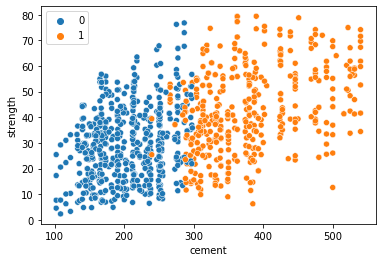

In [43]:
sns.scatterplot(X.cement, y.strength, hue= labels)

In [44]:
df_copy.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29


<AxesSubplot:xlabel='slag', ylabel='strength'>

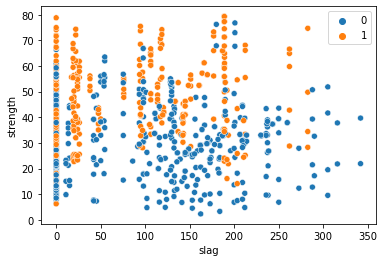

In [45]:
sns.scatterplot(X.slag, y.strength, hue= labels)

<AxesSubplot:xlabel='ash', ylabel='strength'>

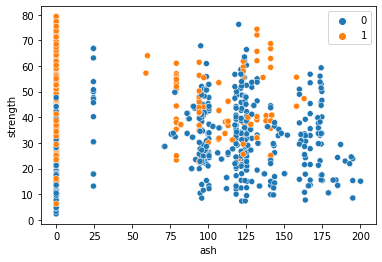

In [46]:
sns.scatterplot(X.ash, y.strength, hue= labels)

<AxesSubplot:xlabel='water', ylabel='strength'>

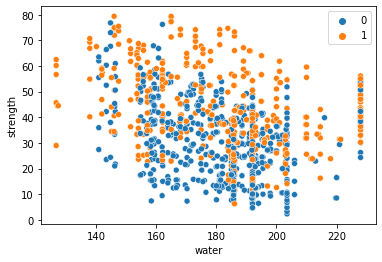

In [47]:
sns.scatterplot(X.water, y.strength, hue= labels)

<AxesSubplot:xlabel='superplastic', ylabel='strength'>

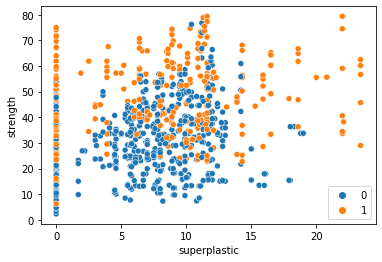

In [48]:
sns.scatterplot(X.superplastic, y.strength, hue= labels)

<AxesSubplot:xlabel='coarseagg', ylabel='strength'>

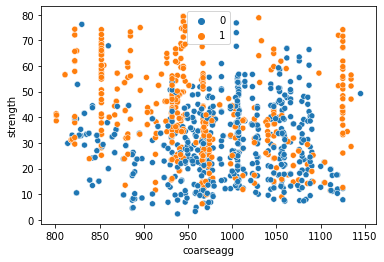

In [49]:
sns.scatterplot(X.coarseagg, y.strength, hue= labels)

<AxesSubplot:xlabel='fineagg', ylabel='strength'>

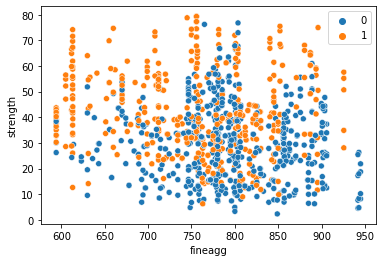

In [50]:
sns.scatterplot(X.fineagg, y.strength, hue= labels)

<AxesSubplot:xlabel='age', ylabel='strength'>

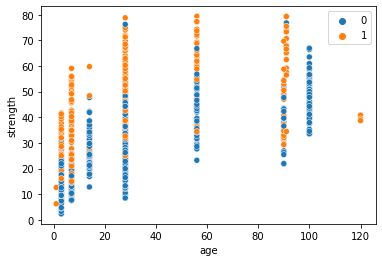

In [51]:
sns.scatterplot(X.age, y.strength, hue= labels) ## age is not havng cluster

In [52]:
labels

array([0, 0, 0, ..., 0, 1, 1])

In [53]:
labels_df = pd.DataFrame(labels,columns= ['labels'] )

In [54]:
new_df = df_copy.join(labels_df, how = 'left')

In [55]:
new_df

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength,labels
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89,0
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51,0
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22,0
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85,1
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29,0
...,...,...,...,...,...,...,...,...,...,...
1025,135.0,0.0,166.0,180.0,10.0,961.0,805.0,28,13.29,0
1026,531.3,0.0,0.0,141.8,6.4,852.1,893.7,3,41.30,1
1027,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28,0
1028,342.0,38.0,0.0,228.0,0.0,932.0,670.0,28,55.06,1


# Generating Learning Curves